## AI手势识别


### 项目任务：基于MobilenetV2和EfficientNet_b_0开发了一个可以在Android手机上进行手势识别的AI应用


## 1、数据准备与加载


### 1.1数据集介绍和下载

本案例所用到的手势数据集[hand gesture cricket(手势板球)](https://www.kaggle.com/datasets/aryanrishilamba/hand-gesture-cricket)，该数据集有10种手势类别和1个nothing类别，每个1张推理图像。
具体数据集内容如下所示:![数据集](./pic/datashow.png)
在这里我们推荐使用kaggle官方的API下载数据集，这样下载的速度比较块。下面以Ubuntu系统为例介绍如何使用：\
在终端依次执行
>pip install kaggle \
>kaggle competitions list \
>cd ~ && mkdir .kaggle

进入kaggle，点击账户头像 -> my account -> 点击Create New API Token，下载kaggle.json文件，并将其放入'~/.kaggle'文件夹下\
进入数据集界面点击右下角'Version2'在弹出的界面选择'Version1'，然后点击数据集Version1界面的右上角,点击"Copy Api Command"\
在终端的工作目录下执行该commad，就可以将数据集快速下载到工作目录下。\
解压后的数据集的目录结构如下所示：

```text
My_Hand_Gesture_Dataset
│   ├── Testing_Data
│   │   ├── 1
│   │   ├── 2
   ...
│   │   ├── 10
│   │   └── Nothing
│   └── Training_Data
│       ├── 1
   ...
│       ├── 10
│       └── Nothing
```

### 1.2加载数据集

采用一些基本的图像增强和图像预处理操作，并构建加载训练数据集和验证数据集用于后续的模型训练和验证。

In [15]:
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as vision

def create_dataset(path, batch_size=16, train=True, image_size=224):
    classindex = {"1" : 0, "2" : 1, "3" : 2, "4" : 3, "5" : 4, "6" : 5, "7" : 6, "8" : 7, "9" : 8, "10" : 9, "Nothing" : 10}
    dataset = ds.ImageFolderDataset(path, num_parallel_workers=4, class_indexing=classindex)
    # 图像增强操作
    mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
    std = [0.229 * 255, 0.224 * 255, 0.225 * 255]
    if train:
        trans = [
            vision.RandomCropDecodeResize(image_size, scale=(0.08, 1.0), ratio=(0.75, 1.333)),
            vision.RandomHorizontalFlip(prob=0.5),
            vision.Normalize(mean=mean, std=std),
            vision.HWC2CHW()
        ]
    else:
        trans = [
            vision.Decode(),
            vision.Resize(256),
            vision.CenterCrop(image_size),
            vision.Normalize(mean=mean, std=std),
            vision.HWC2CHW()
        ]

    dataset = dataset.map(operations=trans, input_columns="image", num_parallel_workers=8)
    # 设置batch_size的大小，若最后一次抓取的样本数小于batch_size，则丢弃
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset


# 加载训练数据集
train_path = "./My_Hand_Gesture_Dataset/Training_Data"
dataset_train = create_dataset(train_path, train=True)

# 加载验证数据集
val_path = "./My_Hand_Gesture_Dataset/Testing_Data"
dataset_val = create_dataset(val_path, train=False)

## 2、模型介绍


### 模型训练

本案例使用预训练模型在手势的分类数据集上对模型进行微调，并将训练好的CKPT模型文件转换为MINDIR格式，用于后续手机侧的部署\
MobileNet V2模型原理\
MobileNet网络是由Google团队于2017年提出的专注于移动端、嵌入式或IoT设备的轻量级CNN网络，相比于传统的卷积神经网络，MobileNet网络使用深度可分离卷积（Depthwise Separable Convolution）的思想在准确率小幅度降低的前提下，大大减小了模型参数与运算量。并引入宽度系数 $\alpha$ 和分辨率系数 $\beta$ 使模型满足不同应用场景的需求。\
由于MobileNet网络中Relu激活函数处理低维特征信息时会存在大量的丢失，所以MobileNetV2网络提出使用倒残差结构（Inverted residual block）和Linear Bottlenecks来设计网络，以提高模型的准确率，且优化后的模型更小。\
![mobilenet](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.7/tutorials/source_zh_cn/beginner/images/mobilenet.png)

图中Inverted residual block结构是先使用1x1卷积进行升维，然后使用3x3的DepthWise卷积，最后使用1x1的卷积进行降维，与Residual block结构相反。Residual block是先使用1x1的卷积进行降维，然后使用3x3的卷积，最后使用1x1的卷积进行升维。

>[详细内容可参见MobileNet V2论文](https://arxiv.org/pdf/1801.04381.pdf)

## 3、模型训练和转换

模型训练的说明\
项目训练MobelnetV2时，使用预训练模型对模型进行微调，并将训练好的CKPT模型文件转换为MINDIR格式，用于后续手机侧的部署。

In [16]:
##下载预训练模型
from mindvision.dataset import DownLoad

models_url = "https://download.mindspore.cn/vision/classification/mobilenet_v2_1.0_224.ckpt"
dl = DownLoad()
# 下载预训练模型文件
dl.download_url(models_url)

### MobileNet V2模型微调

继续使用MobileNet V2的预训练模型进行微调，通过删除MobileNet V2预训练模型中最后一个用于分类的1x1的卷积层的参数，使用手势数据集对模型进行重新训练以更新模型参数。

In [17]:
import mindspore.dataset.vision.c_transforms as vision
from mindvision.classification.models import mobilenet_v2
import mindspore as ms
import mindspore.nn as nn
import mindspore.nn as nn
from mindspore import load_checkpoint
from mindspore import load_param_into_net
from mindvision.classification.models import mobilenet_v2
from mindvision.engine.loss import CrossEntropySmooth
from PIL import Image
import matplotlib.pyplot as plt

In [18]:
# 创建模型,其中目标分类数为2，图像输入大小为(224,224)
network = mobilenet_v2(num_classes=11, resize=224)
# 模型参数存入到param_dict
param_dict = ms.load_checkpoint("./mobilenet_v2_1.0_224.ckpt")
# 获取mobilenet_v2网络最后一个卷积层的参数名
filter_list = [x.name for x in network.head.classifier.get_parameters()]

# 删除预训练模型的最后一个卷积层
def filter_ckpt_parameter(origin_dict, param_filter):
    for key in list(origin_dict.keys()):
        for name in param_filter:
            if name in key:
                print("Delete parameter from checkpoint: ", key)
                del origin_dict[key]
                break

filter_ckpt_parameter(param_dict, filter_list)
# 加载预训练模型参数作为网络初始化权重
ms.load_param_into_net(network, param_dict)
# 定义优化器
# network_opt = nn.Momentum(params=network.trainable_params(), learning_rate=0.01, momentum=0.9)
network_opt = nn.Adam(params=network.trainable_params())
# 定义损失函数
network_loss = CrossEntropySmooth(sparse=True, reduction="mean", smooth_factor=0.1, classes_num=11)
# network_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
# 定义评价指标
metrics = {"Accuracy": nn.Accuracy()}
# 初始化模型
model = ms.Model(network, loss_fn=network_loss, optimizer=network_opt, metrics=metrics)

[WARNING] ME(12734:140419134243008,MainProcess):2022-07-04-13:13:00.352.1 [mindspore/train/serialization.py:645] For 'load_param_into_net', 2 parameters in the 'net' are not loaded, because they are not in the 'parameter_dict', please check whether the network structure is consistent when training and loading checkpoint.
[WARNING] ME(12734:140419134243008,MainProcess):2022-07-04-13:13:00.464.1 [mindspore/train/serialization.py:650] head.classifier.weight is not loaded.
[WARNING] ME(12734:140419134243008,MainProcess):2022-07-04-13:13:00.542.7 [mindspore/train/serialization.py:650] head.classifier.bias is not loaded.


Delete parameter from checkpoint:  head.classifier.weight
Delete parameter from checkpoint:  head.classifier.bias
Delete parameter from checkpoint:  moments.head.classifier.weight
Delete parameter from checkpoint:  moments.head.classifier.bias


### 模型训练

训练mobilenetV2时，我们将数据集在服务器上下载，并在服务器上运行train_mobilenet.py对模型进行训练，并将训练好的模型进行模型转换。然后将ckpt和mindir模型分别传送到本地，在本地使用CPU进行推理验证\
我们以训练3个epoch为例，展示训练过程
![训练过程](./pic/trainmobelnet.png)

In [19]:
# from mindvision.engine.callback import ValAccMonitor
# from mindspore.train.callback import TimeMonitor
# num_epochs = 10
# # 模型训练与验证，训练完成后保存验证精度最高的ckpt文件（best.ckpt）到当前目录下
# model.train(num_epochs,dataset_train,
#             callbacks=[ValAccMonitor(model, dataset_val, num_epochs), TimeMonitor()])

### 测试模型效果


In [20]:
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
import mindspore as ms
from mindvision.classification.models import mobilenet_v2
from mindspore import load_checkpoint
from mindspore import load_param_into_net
from mindspore import Tensor

class_en = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'nothing']

def visualize_model(path, model):
    image = Image.open(path).convert("RGB")
    image = image.resize((224, 224))
    plt.imshow(image)
    # 归一化处理
    mean = np.array([0.485 * 255, 0.456 * 255, 0.406 * 255])
    std = np.array([0.229 * 255, 0.224 * 255, 0.225 * 255])
    image = np.array(image)
    image = (image - mean) / std
    image = image.astype(np.float32)
    # 图像通道由(h, w, c)转换为(c, h, w)
    image = np.transpose(image, (2, 0, 1))
    # 扩展数据维数为(1, c, h, w)
    image = np.expand_dims(image, axis=0)
    # 模型预测
    pre = model.predict(Tensor(image))
    result = np.argmax(pre)
    plt.title(f"Label {path[12:-4]}  Predict: {class_en[result]}")
    plt.xticks([])
    plt.yticks([])
    return result

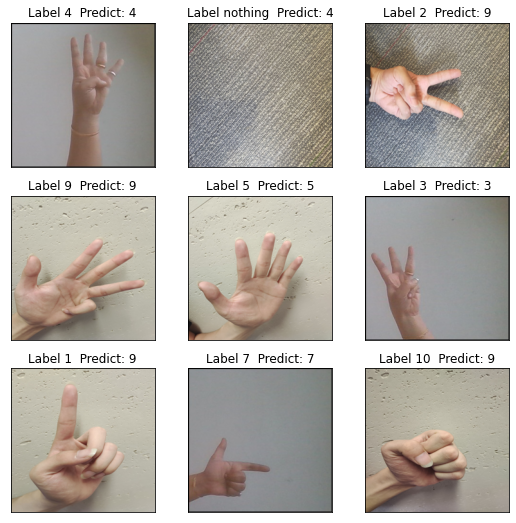

In [21]:
# 定义并加载网络
net = mobilenet_v2(num_classes=11, resize=224)
param_dict = load_checkpoint("./trainmodel/mobelv2.ckpt")
load_param_into_net(net, param_dict)
model = ms.Model(net)
# 获取测试图像
data_path = './data'
images_list = [os.path.join(data_path, img) for img in os.listdir(data_path)]
# 对测试文件夹下的图像进行推理展示
plt.figure(figsize=(9, 9))
for i in range(9):
    plt.subplot(3, 3, i+1)
    visualize_model(path=images_list[i], model=model)
plt.show()

In [22]:
# 模型转换导出
from mindspore import export
from mindspore import Tensor

# 定义并加载网络参数
net = mobilenet_v2(num_classes=11, resize=224)
param_dict = load_checkpoint("./trainmodel/mobelv2.ckpt")
load_param_into_net(net, param_dict)
# 将模型由ckpt格式导出为MINDIR格式
input_np = np.random.uniform(0.0, 1.0, size=[1, 3, 224, 224]).astype(np.float32)
export(net, Tensor(input_np), file_name="mobilenet_v2_1.0_224", file_format="MINDIR")

## 3、模型部署与验证


自定义标签文件custom.json
>{
    "title": '手势识别',
    "file": 'mobilenet_v2_1.0_224.ms',
    "label": ['1','2','3','4','5','6','7','8','9','10','nothing']
>}

将标签文件和转换后的模型文件mobilenet_v2_1.0_224.ms一起放置到手机上指定目录下。之后进行终端的部署推理

### 标签与模型文件部署到手机

在`MindSpore Vision APK`的首页上长按`分类`按钮，可以进入自定义分类模式，并且选择需要部署的标签和模型文件。\
为实现手机端手势识别功能，需将标签文件`custom.json`文件和模型文件`mobilenet_v2_1.0_224.ms`一起放置到手机上指定目录下。这里以`Android/data/Download/` 文件夹为例，首先把标签文件和模型文件同时放在上述手机地址，如图所示，点击自定义按钮，然后会弹出系统文件功能，点击左上角的打开文件，然后找到Json标签文件和模型文件存放的目录地址，并选择对应的Json文件。

### 模型部署展示

将标签与模型文件部署到手机后，即可点击中间按钮进行拍照获取图片，或者点击上侧栏的图像按钮选择图片相册用于图像，就可以进行手势的分类识别。手机端测试效果如下：

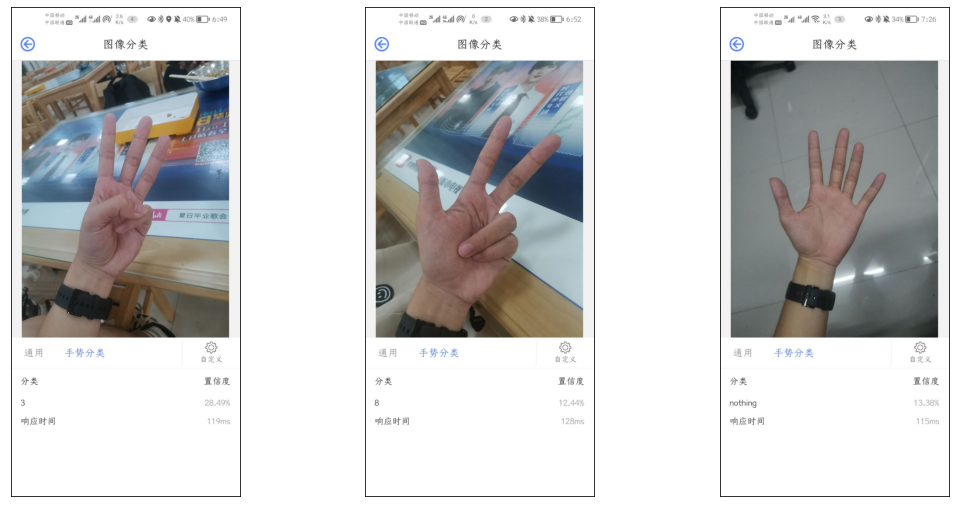

In [23]:
plt.figure(figsize=(18, 9))
img1 = Image.open('./pic/op1.jpg')
plt.subplot(1, 3, 1)
plt.imshow(img1)
plt.xticks([])
plt.yticks([])
img2 = Image.open('./pic/op2.jpg')
plt.subplot(1, 3, 2)
plt.imshow(img2)
plt.xticks([])
plt.yticks([])
img2 = Image.open('./pic/op4.jpg')
plt.subplot(1, 3, 3)
plt.imshow(img2)
plt.xticks([])
plt.yticks([])
plt.show()

以上实现了基于MobilenetV2的手势识别应用的实现与部署，下面我们对训练的模型预测的效果和准确度进行分析，并使用efficientnet_b0网络测试识别效果

## 基于MobelnetV2的准确度分析


### 模型推理效果分析

我们针对模型的实际预测效果进行测试，发现模型的准确率不是很高，我们主要对模型数据集进行分析，并对推理时的图像进行亮度和对比度的调整，进一步分析模型预测的准确度
>1、数据集图像内容及结构分析\
>2、调整输入图像亮度和对比度

1、通过分析数据集中的图像，很容易发现训练数据集中的图像数量很多，每个类别下有4000张图像，但是图像间手势的差异不明显，例如类别3下的图像数据如下图。对于手势图像，其中背景和手势区别明显，背景单一，有助于模型学习到手势的关键特征，但是我们在测试时很容易发现：在实际测试时，背景单一的手势照片更容易被网络识别为nothing，可以认为识别不到图像中的手势，对于背景丰富的手势图像数据，反而有更好的识别效果，虽然很多时候的识别也是错误的类型。数据集中手势图像还有一个明显的特点：所有的图像的手势都是立起来摆放的手势，缺少一些横着摆放和其他角度的手势，可能与受限于数据集的实际背景，这是种hand gesture cricket(手势板球)，以及作者构建数据集的核心训练任务等，整个数据集也在更新内容，最初使用时只有V1版本，后来作者更新了V2版本的数据集增加了二值图像，目前也在更新V3版本。
![datafigure](./pic/data-fiture.png)

2、为了减少背景对预测模型的影响，我们针对测试图像，在推理前的图像预处理是，增加了对图像亮度和对比度的调整，并经一部探究模型的识别效果

In [24]:
import matplotlib.pyplot as plt
import os
import numpy as np
import mindspore as ms
from mindvision.classification.models import mobilenet_v2
from mindspore import load_checkpoint
from mindspore import load_param_into_net
from mindspore import Tensor
from PIL import Image
from PIL import ImageEnhance

class_en = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'nothing']

def infer_one(path, model, tag=False):
    image = Image.open(path)
    image = data_pre(image, preplus=tag)
    # 图像通道由(h, w, c)转换为(c, h, w)
    image = np.transpose(image, (2, 0, 1))
    # 扩展数据维数为(1, c, h, w)
    image = np.expand_dims(image, axis=0)
    # 模型预测
    pre = model.predict(Tensor(image))
    result = np.argmax(pre)
    print("Label:%10s  Predict:%5s "%(path[10:-5], class_en[result]))
    return result

def data_pre(img, preplus=False):
    image = img.resize((224, 224))
    if preplus:
        enh_bri = ImageEnhance.Brightness(image)
        brightness = 0.7
        image = enh_bri.enhance(brightness)
        enh_con = ImageEnhance.Contrast(image)
        contrast = 1.5
        image = enh_con.enhance(contrast)
    # 归一化处理
    mean = np.array([0.485 * 255, 0.456 * 255, 0.406 * 255])
    std = np.array([0.229 * 255, 0.224 * 255, 0.225 * 255])
    image = np.array(image)
    image = (image - mean) / std
    image = image.astype(np.float32)
    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


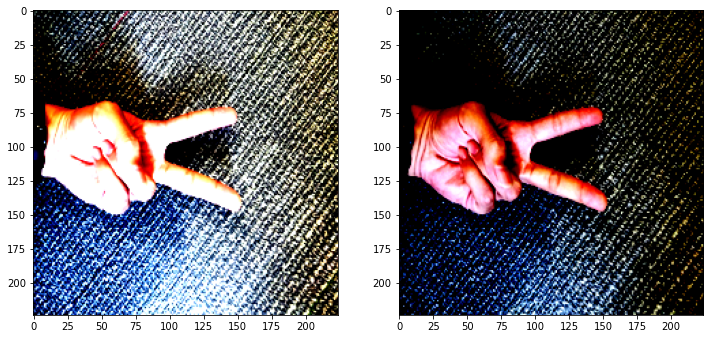

In [25]:
img = './data/test-2.jpg'
image = Image.open(img)
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.imshow(data_pre(image))
plt.subplot(1, 2, 2)
plt.imshow(data_pre(image, preplus=True))
plt.show()

In [26]:
# 定义并加载网络
net = mobilenet_v2(num_classes=11, resize=224)
param_dict = load_checkpoint("./best.ckpt")
load_param_into_net(net, param_dict)
model = ms.Model(net)
# 获取测试图像
data_path = './shoushi/'
images_list = [os.path.join(data_path, img) for img in os.listdir(data_path)]
print("第一行只进行图像裁减归一化  第二行增加亮度和对比度调整")
print('.....................................')
# 对测试文件夹下的图像进行推理展示
for i in range(9):
    infer_one(path=images_list[i], model=model)
    infer_one(path=images_list[i], model=model, tag=True)
    print('.....................................')

第一行只进行图像裁减归一化  第二行增加亮度和对比度调整
.....................................
Label:        10  Predict:    1 
Label:        10  Predict:    1 
.....................................
Label:         6  Predict:    6 
Label:         6  Predict:    6 
.....................................
Label:         5  Predict:    7 
Label:         5  Predict:    4 
.....................................
Label:   nothing  Predict:   10 
Label:   nothing  Predict:nothing 
.....................................
Label:         3  Predict:    3 
Label:         3  Predict:    3 
.....................................
Label:         8  Predict:    7 
Label:         8  Predict:    1 
.....................................
Label:         4  Predict:    4 
Label:         4  Predict:    3 
.....................................
Label:         2  Predict:    3 
Label:         2  Predict:    3 
.....................................
Label:   nothing  Predict:   10 
Label:   nothing  Predict:nothing 
...............................

通过对上面图片亮度和对比度的调整，我们发现该操作可以让预处理后的模型中手势和背景的对比度明显降低，以及让手势特征更为明显，对于一些有明显类别检的检测错误的图像效果变化不明显，但是针对nothing类别的图像有明显的提高。

### 手机端效果分析

>手机端主要受手势的背景影响严重

根据上面手机端部署的结果，以及我们详细的测试和对比发现，手机端的检测受手势的背景影响严重，具体表现在：当背景单一，即手势和背景对比明显时，会首背景影响严重，输出为nothing。相反，当背景丰富时，更容易识别出手势的类别

## 使用efficientnet_b0进行分类


Efficient网络\
我们直接调用mindvision中的efficientnet_b0，使用Adam优化器，采用使用相同的图像增强策略和损失函数，搭建新的分类模型\
由于不能合理加载与训练模型参数，我们直接训练模型参数，训练efficientnet时，在服务器上运行train_efficientnet.py对模型进行训练，并将训练好的模型进行模型转换。然后将ckpt和mindir模型分别传送到本地，由于模型不能在本地使用CPU进行推理验证，我们同样在服务器上进行数据推理验证\
我们同样以训练3个epoch为例，展示训练过程。\
对比模型训练过程可以发现，相比于Mobelnet加载预训练模型参数，其模型的准确率逐渐提高，模型可以在很小的几个epoch快达到很高的准确率。
![traineffnet.png](./pic/traineffnet.png)

### efficientnet_b0推理验证


In [27]:
# import matplotlib.pyplot as plt
# import os
# import numpy as np
# from PIL import Image
# import mindspore as ms
# from mindvision.classification.models import efficientnet_b0
# from mindspore import load_checkpoint,load_param_into_net
# from mindspore import Tensor

# class_en = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'nothing']
# def visualize_model(path,model):
#     image = Image.open(path).convert("RGB")
#     image = image.resize((224, 224))
#     # 归一化处理
#     mean = np.array([0.485 * 255, 0.456 * 255, 0.406 * 255])
#     std = np.array([0.229 * 255, 0.224 * 255, 0.225 * 255])
#     image = np.array(image)
#     image = (image - mean) / std
#     image = image.astype(np.float32)
#     # 图像通道由(h, w, c)转换为(c, h, w)
#     image = np.transpose(image, (2, 0, 1))
#     # 扩展数据维数为(1, c, h, w)
#     image = np.expand_dims(image, axis=0)
#     # 模型预测
#     pre = model.predict(Tensor(image))
#     result = np.argmax(pre)
#     print("Label:%10s  Predict:%5s "%(path[12:-4],class_en[result]))
#     return result
# # 定义并加载网络
# net = efficientnet_b0(num_classes=11)
# param_dict = load_checkpoint("./trainmodel/efficientmodel.ckpt")
# load_param_into_net(net, param_dict)
# model = ms.Model(net)
# # 获取测试图像
# data_path = './data'
# images_list = [os.path.join(data_path, img) for img in os.listdir(data_path)]
# # 对测试文件夹下的图像进行推理展示
# for i in range(9):
#     visualize_model(path=images_list[i],model=model)

![train erro](./pic/error.png)
上面的程序会产生报错，分析原因：该模型不支持使用CPU进行推理

我们在服务器上运行该段测试程序，并将结果进行保存，展示，其中模型预测效果如下：
![evaldata](./pic/eval-effnet.png)

采用部署MobelnetV2相同的方法，对模型进行转换，并将转换的ms文件传到手机上，在手机设备上进行推理。具体的推理的结果如下：

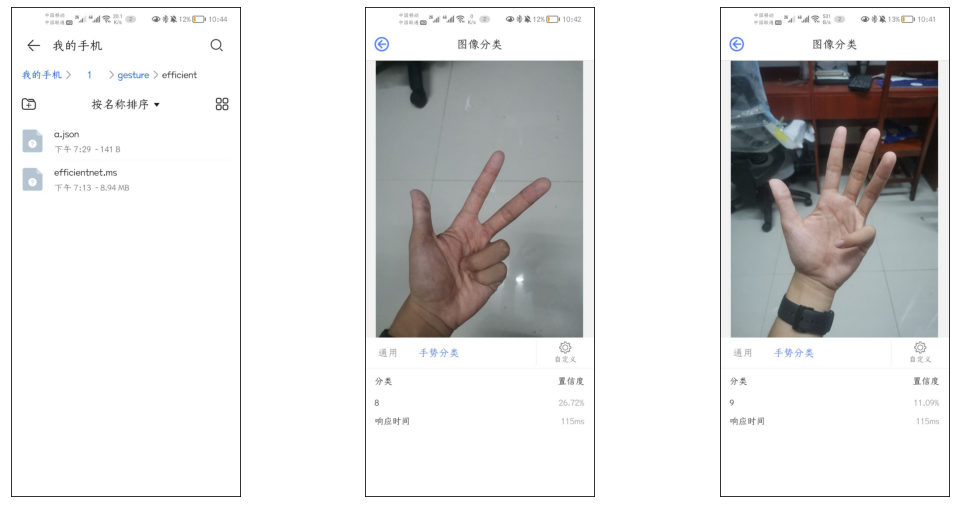

In [28]:
# plt.imread('./pic/datashow.png')
plt.figure(figsize=(18, 9))
img1 = Image.open('./pic/info.jpg')
plt.subplot(1, 3, 1)
plt.imshow(img1)
plt.xticks([])
plt.yticks([])
img2 = Image.open('./pic/effnet-8.jpg')
plt.subplot(1, 3, 2)
plt.imshow(img2)
plt.xticks([])
plt.yticks([])
img2 = Image.open('./pic/effnet-9.jpg')
plt.subplot(1, 3, 3)
plt.imshow(img2)
plt.xticks([])
plt.yticks([])
plt.show()